In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
from film import FilmSimple
from spectrum import Spectrum
from design import Design

from analyze_utils.structure import plot_layer_thickness
from optimizer.adam import adam_optimize
import pickle



In [4]:
def make_edgefilter_design(init_film: FilmSimple):
    inc_ang = 0.
    wls = np.linspace(400, 1000, 500) # when wls = 50, ~100 min
    # R = np.ones(wls.shape[0] , dtype='float')
    R = np.zeros(wls.shape[0] , dtype='float')
    R[wls.shape[0] // 2:] = 1.
    target_spec = [Spectrum(inc_ang, wls, R)]
    
    design = Design(target_spec, init_film)
    return design


def make_reflection_design(init_film: FilmSimple):
    inc_ang = 0.
    wls = np.linspace(400, 1000, 500) # when wls = 50, ~100 min
    R = np.ones(wls.shape[0] , dtype='float')
    target_spec = [Spectrum(inc_ang, wls, R)]
    
    design = Design(target_spec, init_film)
    return design



In [ ]:

init_ots = np.arange(1, 20000, 2000)
layer_numbers = np.arange(1, 200, 10)
rep_number = 3

for init_ot in init_ots:
    for rep in range(rep_number):

        for layer_number in layer_numbers:
            np.random.seed(rep)
            d = np.random.random(layer_number)
            init_film = FilmSimple('SiO2', 'TiO2', 'SiO2', d)
            d *= init_ot / (init_film.get_optical_thickness(700.)) # roughly 1000 nm ot
            
            design = make_reflection_design(init_film)
            losses = adam_optimize(design.film, design.target_specs, 5000, alpha=1, show=True, record=True)
            
            fname = f'./raw_result/back_reflector/SiO2_TiO2-400to1000nm-700nm/ot{init_ot}_layer{layer_number}_rep{rep}_design.pkl'
            with open(fname, 'wb') as f:
                pickle.dump(design, f)

0.08188497010455226
1991.697019708768
2430.974257268008
17


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(<AxesSubplot: title={'center': 'refractive index distribution at  701 nm'}, xlabel='position / nm'>,
 <Figure size 600x100 with 1 Axes>)

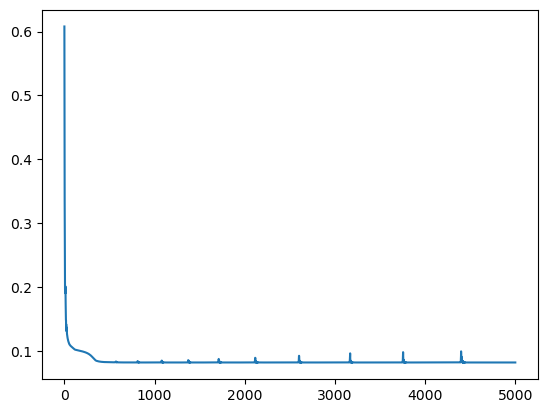

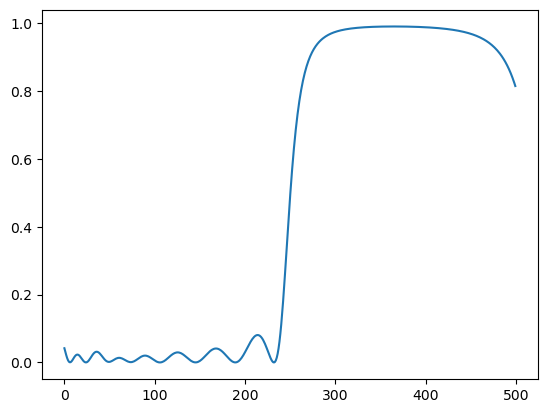

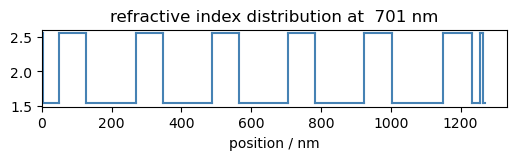

In [3]:
print(design.calculate_loss())
print(design.get_init_ot())
print(design.get_current_ot())
design.film.remove_negative_thickness_layer()
print(design.film.get_layer_number())

import matplotlib.pyplot as plt
plt.plot(losses)

fig, ax = plt.subplots(1, 1)
ax.plot(design.film.get_spec().get_R())

plot_layer_thickness(design.film)


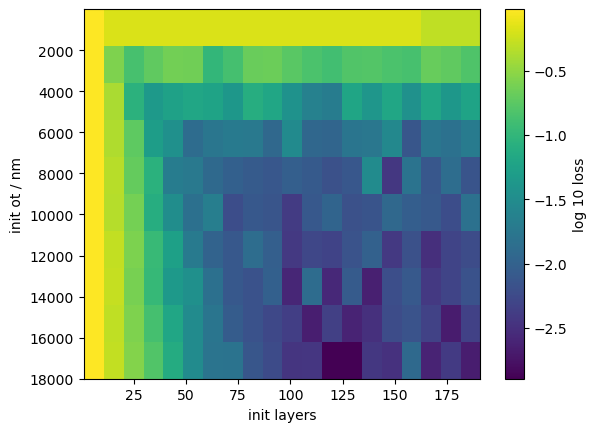

In [17]:
init_ots = np.arange(1, 20000, 2000)
layer_numbers = np.arange(1, 200, 10)
rep_number = 3

rep = 2


loss_arr: list[list[float]] = []
for init_ot in init_ots:
    loss_arr.append([])
    for layer_number in layer_numbers:
        fname = f'./raw_result/back_reflector/SiO2_TiO2-400to1000nm-700nm/ot{init_ot}_layer{layer_number}_rep{rep}_design.pkl'
        with open(fname, 'rb') as f:
            design: Design = pickle.load(f)
        loss_arr[-1].append(design.calculate_loss())


fig, ax = plt.subplots(1, 1)
s = ax.imshow(
    np.log10(loss_arr), 
    aspect='auto', 
    extent=[layer_numbers[0], layer_numbers[-1], init_ots[-1], init_ots[0]], 
        
)
ax.set_xlabel('init layers')
ax.set_ylabel('init ot / nm')
cbar = fig.colorbar(s)
cbar.set_label('log 10 loss')



Text(0, 0.5, 'final layer number (zero thickness removed)')

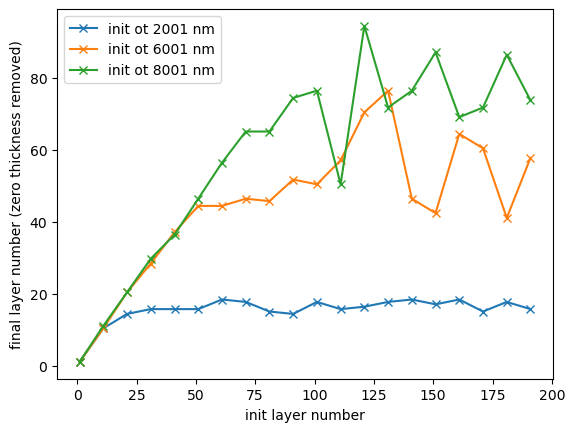

In [46]:
rep_number = 3
init_layer = []
final_layer = []
for init_ot in init_ots:
    init_layer.append([])
    final_layer.append([])
    for layer_number in layer_numbers:
        avg_init_layer_num = 0
        avg_final_layer_num = 0
        for rep in range(rep_number):
            fname = f'./raw_result/back_reflector/SiO2_TiO2-400to1000nm-700nm/ot{init_ot}_layer{layer_number}_rep{rep}_design.pkl'
            with open(fname, 'rb') as f:
                design: Design = pickle.load(f)
            design.film.remove_negative_thickness_layer()
            avg_init_layer_num += design.init_film.get_layer_number() / rep_number
            avg_final_layer_num += design.film.get_layer_number() / rep_number
        init_layer[-1].append(avg_init_layer_num)
        final_layer[-1].append(avg_final_layer_num)


fig, ax = plt.subplots(1, 1)
for init_ot, init_layer_ls, final_layer_ls in zip(init_ots, init_layer, final_layer):
    if init_ot not in [2001, 6001, 8001, 18001]:
        continue
    ax.plot(init_layer_ls, final_layer_ls, marker='x', label=f'init ot {init_ot} nm')
ax.legend()
ax.set_xlabel('init layer number')
ax.set_ylabel('final layer number (zero thickness removed)')

In [53]:
rep_number = 3
final_ot = []
for layer_number in layer_numbers:
    final_ot.append([])
    for init_ot in init_ots:
        avg_init_ot = 0
        avg_final_ot = 0
        for rep in range(rep_number):
            fname = f'./raw_result/back_reflector/SiO2_TiO2-400to1000nm-700nm/ot{init_ot}_layer{layer_number}_rep{rep}_design.pkl'
            with open(fname, 'rb') as f:
                design: Design = pickle.load(f)
            design.film.remove_negative_thickness_layer()
            avg_init_ot += design.init_film.get_optical_thickness(700.) / rep_number
            avg_final_ot += design.film.get_optical_thickness(700.) / rep_number
        final_ot[-1].append(avg_final_ot)


fig, ax = plt.subplots(1, 1)
for layer_number, final_ot_ls in zip(layer_numbers, final_ot):
    if layer_number not in [1, 21, 91, 191]:
        continue

    ax.plot(init_ots, final_ot_ls, marker='x', label=f'{layer_number}')
ax.legend()
ax.set_xlabel('init layer number')
ax.set_ylabel('final layer number (zero thickness removed)')

Text(0, 0.5, 'final layer number (zero thickness removed)')

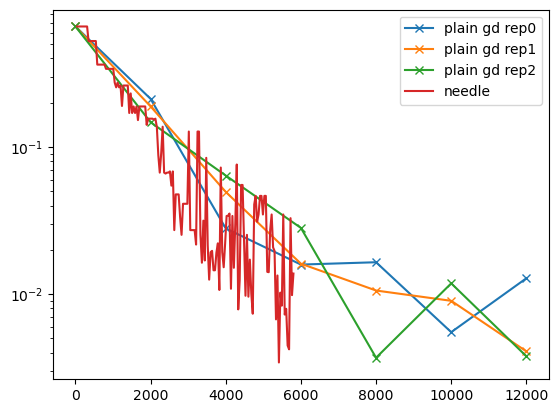

In [43]:
# load gd design
init_ots = np.arange(1, 14000, 2000)
layer_number = 151
rep_number = 3
losses = [[] for _ in range(rep_number)]
for init_ot in init_ots:    
    for rep in range(rep_number):
        fname = f'./raw_result/back_reflector/SiO2_TiO2-400to1000nm-700nm/ot{init_ot}_layer{layer_number}_rep{rep}_design.pkl'
        with open(fname, 'rb') as f:
            design: Design = pickle.load(f)
        losses[rep].append(design.calculate_loss())

# load needle design
losses_needle = []
init_ots_needle = []
for run_num in range(1, 151):
    fname = f'./../needle_training/raw_result/single_inc/reflection-0_inc-400to1000wls-init_single_layer_SiO2/{run_num}_design.pkl'
    with open(fname, 'rb') as f:
        design = pickle.load(f)
        losses_needle.append(design.calculate_loss())
        init_ots_needle.append(design.get_init_ot())





fig, ax = plt.subplots(1, 1)
for rep in range(rep_number):
    ax.plot(init_ots, [x for x in losses[rep]], label=f'plain gd rep{rep}', marker='x')
ax.plot(init_ots_needle, losses_needle, label='needle')
ax.legend()
ax.set_yscale('log')
